# Fine Mapping

I want to take the significant eQTL variants and functionally annotate them
to try to determine which variants might be causal.

I'd like to annotate the variants with various functional annotations. I'd also
like to search for TF motif disruptions and perhaps use phasing information
and allelic bias.

In [113]:
import cPickle
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'fine_mapping'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants_single.tsv')
lead_variants_single = pd.read_table(fn, index_col=0)
lead_variants_single_f = lead_variants_single[lead_variants_single.perm_sig]

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'gene_variant_pairs.tsv')
gene_variants = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

ensg = pd.Series(gene_info.index, index=[x.split('.')[0] for x in gene_info.index])

In [3]:
# ASE results.
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

I'll drop CNVs since they likely act through different mechanisms than I'm considering here.

In [4]:
gene_variants = gene_variants[gene_variants.variant_type != 'cnv']

## Predicted NMD

I'll use the snpEff annotation of the WGS to look for predicted NMD. I'd like to
see if any of the significant variants are predicted to cause NMD for the eQTL
gene.

If snpEff predicts NMD for a gene, the annotation looks like

    PITRM1|ENSG00000107959|11|0.27
    
This means that PITRM1 has 11 transcripts and 27% of them are predicted to have NMD.

In [5]:
fns = glob.glob('/projects/CARDIPS/pipeline/WGS/mergedVCF/annotation/vcf/*snpeff.vcf.gz')
fns = [x for x in fns if len(re.findall('chr\d{1,2}', x)) > 0]
fns = pd.Series(fns, index=[re.findall('chr\d{1,2}', x)[0] for x in fns])

for vcf in fns.values:
    out = os.path.join(private_outdir, os.path.split(vcf)[1].replace('.vcf.gz', '_nmd.vcf'))
    if not os.path.exists(out):
        !zcat {vcf} | java -jar /software/snpEff_v4_1l_core/SnpSift.jar filter "NMD[*]" > {out}

In [6]:
fns = glob.glob(os.path.join(private_outdir, '*_nmd.vcf'))
variants = []
nmd = []
for fn in fns:
    vcf_reader = pyvcf.Reader(open(fn))
    for r in vcf_reader:
        variants.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS))
        nmd.append(r.INFO['NMD'])
ind = []
vals = []
for i, v in enumerate(variants):
    r = nmd[i]
    for n in r:
        gene_name, gene_id, num_t, per_t = n.strip(')').split('|')
        ind.append(v + ':' + ensg[gene_id])
        vals.append([int(num_t), float(per_t)])
nmd = pd.DataFrame(vals, index=ind, columns=['nmd_num_transcripts', 'nmd_percent_transcripts_nmd'])

In [7]:
tdf = nmd.ix[set(nmd.index) & set(gene_variants.index)]

In [8]:
gene_variants = gene_variants.join(tdf)

In [9]:
gene_variants['nmd'] = False
gene_variants.ix[gene_variants.dropna(subset=['nmd_num_transcripts']).index, 'nmd'] = True

In [10]:
g = set(gene_variants.ix[gene_variants.nmd, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_nmd_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_nmd_variant.isnull(), 'gene_has_nmd_variant'] = False

## Exons, UTRs, and Promoters

I'll annotate whether variants fall in exons, UTRs or promoters for their significant
genes.

In [11]:
gene_variants_bt = pbt.BedTool('\n'.join(set(gene_variants.apply(lambda x: '{}\t{}\t{}'.format(
                    x['chrom'], x['start'], x['end']), axis=1))), from_string=True)
gene_variants_bt = gene_variants_bt.sort()

In [12]:
exons = pbt.BedTool(cpy.gencode_exon_bed)
utrs = pbt.BedTool(cpy.gencode_utr_bed)
promoters = pbt.BedTool(cpy.gencode_promoter_bed)

In [13]:
res = gene_variants_bt.intersect(exons, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['exonic_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'exonic_same_gene'] = True

df['exonic'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['exonic']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.exonic.isnull(), 'exonic'] = False

In [14]:
g = set(gene_variants.ix[gene_variants.exonic, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_variant.isnull(), 'gene_has_exonic_variant'] = False

g = set(gene_variants.ix[gene_variants.exonic_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_same_gene_variant.isnull(), 'gene_has_exonic_same_gene_variant'] = False

In [15]:
res = gene_variants_bt.intersect(utrs, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['utr_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'utr_same_gene'] = True

df['utr'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['utr']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.utr.isnull(), 'utr'] = False

In [16]:
res = gene_variants_bt.intersect(promoters, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart.apply(lambda x: x.split('_')[0])].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['promoter_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'promoter_same_gene'] = True

df['promoter'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['promoter']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.promoter.isnull(), 'promoter'] = False

In [17]:
g = set(gene_variants.ix[gene_variants.utr, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_variant.isnull(), 'gene_has_utr_variant'] = False

g = set(gene_variants.ix[gene_variants.utr_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_same_gene_variant.isnull(), 
                'gene_has_utr_same_gene_variant'] = False

g = set(gene_variants.ix[gene_variants.promoter_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_promoter_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_promoter_same_gene_variant.isnull(), 
                'gene_has_promoter_same_gene_variant'] = False

## Maurano et al. 2015 Data

I'm going to grab some data from [Maurano *et al.* 2015](http://www.nature.com/ng/journal/v47/n12/full/ng.3432.html).
The zip file seems to be corrupted. I was able to manually download on my mac 
and decompress it using Arhcive Utility but I couldn't get it work from the
command line so that this has to be downloaded by hand.

In [18]:
# This has all of the variants tested for imbalance and their significance.
maurano_res = pd.read_table('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S5.txt')
# This has SNVs from dbSNP 138 predicted to affect TF binding.
fn = os.path.join(private_outdir, 'ng.3432-S7')
if not os.path.exists(fn):
    print('Download ng.3432-S7, decompress, and add to private_outdir.')
    print('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S7.zip')
else:
    maurano_tf_disrupt = pd.read_table(fn)

In [19]:
se = maurano_res.chromEnd - maurano_res.chromStart
se[se > 1].shape

(0,)

The Maurano results are all SNVs.

In [20]:
print(len(set(maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + '-' + 
              maurano_res.chromEnd.astype(str))))
print(maurano_res.shape[0])

362284
362284


In [21]:
maurano_res.index = (maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + 
                     '-' + maurano_res.chromEnd.astype(str))

The Maurano results are all unique variants.

In [22]:
maurano_res.head(1)

,chrom,chromStart,chromEnd,rs,numhets,allele.1,readsA,allele.2,readsB,totalReads,pctRef,q.value,significance.level
chr1:752720-752721,chr1,752720,752721,snp5,33,G,1583,A,1454,3037,0.479,0.0912,not_imbalanced


It seems that the Maurano data is in zero-based coordinates.

In [23]:
maurano_res.columns = ['{}_maurano'.format(c) for c in maurano_res.columns]
gene_variants = gene_variants.merge(maurano_res, left_on='location', right_index=True, how='left')
gene_variants = gene_variants.drop(['chrom_maurano', 'chromStart_maurano', 'chromEnd_maurano'], axis=1)

I'll also add in the predicted TF disruptions.

In [24]:
maurano_tf_disrupt.columns = ['{}_maurano_tf'.format(x) for x in maurano_tf_disrupt.columns]
maurano_tf_disrupt.index = (maurano_tf_disrupt.chrom_maurano_tf + ':' +
                            maurano_tf_disrupt.snpChromStart_maurano_tf.astype(str) + 
                            '-' + maurano_tf_disrupt.snpChromEnd_maurano_tf.astype(str))
gene_variants = gene_variants.merge(maurano_tf_disrupt, left_on='location', 
                                  right_index=True, how='left')

In [25]:
gene_variants = gene_variants.drop(['chrom_maurano_tf', 'snpChromStart_maurano_tf', 
                                    'snpChromEnd_maurano_tf'], axis=1)

## Roadmap DNase

In [26]:
out = os.path.join(outdir, 'roadmap_dnase.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    df = pd.DataFrame(False, index=set(gene_variants.location), columns=lines)
    for url in urls:
        line = roadmap_ids[os.path.split(url)[1].split('-')[0]]
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values, line] = True
    df = df.ix[:, df.sum() > 0]
    df.columns = [c.replace(' Cell Line', '').replace(' ', '_') + '_roadmap_dnase' for c in df.columns]
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## ENCODE DNase

In [27]:
out = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    bs_types = ['stem cell', 'induced pluripotent stem cell line']
    encode_dnase = encode_dnase[encode_dnase.biosample_type.apply(lambda x: x in bs_types)]

    cols = (encode_dnase.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC')) + 
            '_' + encode_dnase.index + '_dnase')
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=cols)
    encode_dnase['col'] = cols
    for i in encode_dnase.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_dnase.ix[i, 'col']] = True
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## ENCODE Transcription Factor ChIP-Seq

In [28]:
out = os.path.join(outdir, 'encode_tf_chip_seq.tsv')
if not os.path.exists(out):
    encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                    'functional_annotation_analysis', 
                                                    'encode_stem_cell_chip_seq.tsv'), index_col=0)
    encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')


    cols = encode_tf_chip_seq.target + '_tf_chip'
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=cols)
    encode_tf_chip_seq['col'] = cols
    for i in encode_tf_chip_seq.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_tf_chip_seq.ix[i, 'col']] = True

    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## TF Motif Disruption

In [29]:
gene_variants['ref_allele'] = gene_variants.marker_id.apply(lambda x: x.split('/')[0].split('_')[-1])
gene_variants['alt_allele'] = gene_variants.marker_id.apply(lambda x: x.split('/')[1].split('_')[0])

In [30]:
out = os.path.join(outdir, 'tf_disruption.tsv')
if not os.path.exists(out):
    fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
    with open(fn) as f:
        matrices = cPickle.load(f)
    fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
    motif_info = pd.read_table(fn, index_col=0)
    fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
    motif_info_rep = pd.read_table(fn, index_col=0)

    tf_cols = [x for x in gene_variants.columns if 'tf_chip' in x]
    tdf = gene_variants[['location', 'ref_allele', 'alt_allele'] + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.location
    tdf = tdf.drop('location', axis=1)
    tdf = tdf[tdf[tf_cols].sum(axis=1) > 0]
    tdf['tfs'] = tdf.apply(lambda x: set(motif_info.tf) & 
                           set([y.split('_')[0] for y in x[tf_cols][x[tf_cols]].index]), axis=1)
    tdf = tdf[tdf.tfs.apply(lambda x: len(x)) > 0]
    tdf = tdf.drop(tf_cols, axis=1)
    tdf['motif_names'] = tdf.tfs.apply(lambda x: list(motif_info[motif_info.tf.apply(lambda y: y in x)].index))
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            i, tdf.ix[i, 'ref_allele'], tdf.ix[i, 'alt_allele'], cpy.hg19, 
            {k:matrices[k] for k in tdf.ix[i, 'motif_names']}), tdf.index)
    cols = motif_info[motif_info.tf.apply(lambda x: x in [x.split('_')[0] for x in tf_cols])].index
    motif_d = pd.DataFrame(index=tdf.index, columns=cols)
    a = []
    b = []
    for i,p in enumerate(tdf.index):
        if res[i].shape[0] > 0:
            a.append(p)
            b.append(res[i])
    d = dict(zip(a,b))
    p = pd.Panel(d)
    motif_d = p.ix[:, :, 'score_diff'].T
    motif_d.to_csv(out, sep='\t')
else:
    motif_d = pd.read_table(out, index_col=0)

For `motif_d`, the value is reference score minus alternate score. So a positive
value means the reference matched the motif better.

I'm not sure what score difference constitutes a disruption. Let's
take a look at the distribution of differences.

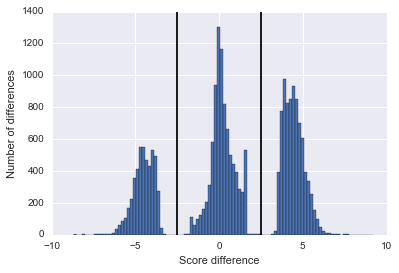

In [31]:
pd.Series(motif_d.values.flatten()).dropna().hist(bins=100)
ymin, ymax = plt.ylim()
plt.vlines(-2.5, ymin, ymax)
plt.vlines(2.5, ymin, ymax)
plt.ylabel('Number of differences')
plt.xlabel('Score difference');

It seems that a score difference greater than 2.5 in magnitude probably
represents a pretty big effect. I'll say these are disruptions.

In [32]:
motif_disrupt = motif_d.abs() >= 2.5
motif_disrupt.columns = ['{}_motif_disrupted'.format(x) for x in motif_disrupt.columns]
gene_variants = gene_variants.merge(motif_disrupt, left_on='location', right_index=True, how='left')

In [33]:
tf_disrupt = motif_disrupt.copy(deep=True)
tf_disrupt.columns = ['{}_tf_disrupted'.format(x.split('_')[0]) for x in tf_disrupt.columns]
d = {}
for c in set(tf_disrupt.columns):
    t = tf_disrupt[c]
    if len(t.shape) > 1:
        d[c] = (tf_disrupt[c].sum(axis=1) == 1).values
    else:
        d[c] = t.values
tf_disrupt = pd.DataFrame(d, index=tf_disrupt.index)
gene_variants = gene_variants.merge(tf_disrupt, left_on='location', right_index=True, how='left')

In [34]:
disrupted_cols = [x for x in gene_variants.columns if '_motif_disrupted' in x]
gene_variants['tf_disruption'] = gene_variants[disrupted_cols].sum(axis=1) > 0

## Phasing and ASE

Let's consider a putative eQTN. Let's assume that the direction of effect is such that
the homozygous alternative genotype has lowest expression. If we have the correct eQTN,
a subject who is het for the putative eQTN should see lower expression for the haplotype
that contains the alt variant. I can check this for SNVs given that our SNVs are phased.

## Feature Exploration

In [35]:
n = (gene_variants.gene_id.value_counts() > 1).value_counts()[False]
print('{:,} of {:,} genes have only one significant variant.'.format(n, len(set(gene_variants.gene_id))))

721 of 5,760 genes have only one significant variant.


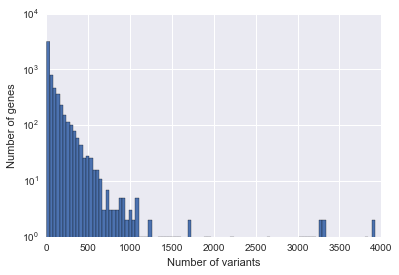

In [36]:
gene_variants.gene_id.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of variants');

In [37]:
gene_gb = gene_variants.groupby('gene_id')
num_genes = len(set(gene_variants.gene_id))

In [38]:
n = (gene_gb.exonic.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant exonic variant.'.format(
    n, num_genes))
m = (gene_gb.exonic_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own exon.'.format(
    m, n))

4,007 of 5,760 genes have at least one significant exonic variant.
3,002 of these 4,007 genes have at least one significant variant in their own exon.


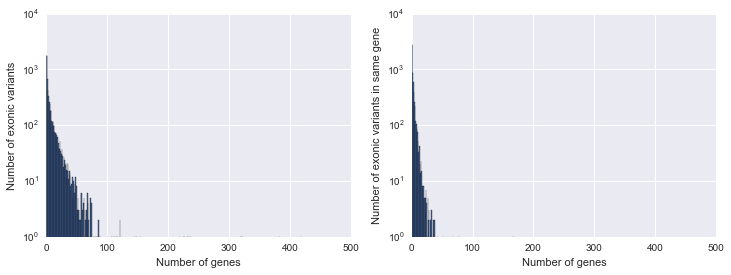

In [39]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.exonic.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[0])
ax.set_ylabel('Number of exonic variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.exonic_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[1])
ax.set_ylabel('Number of exonic variants in same gene')
ax.set_xlabel('Number of genes');

In [40]:
n = (gene_gb.utr.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant UTR variant.'.format(
    n, len(set(gene_variants.gene_id))))
m = (gene_gb.utr_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own UTR.'.format(
    m, n))

3,200 of 5,760 genes have at least one significant UTR variant.
2,050 of these 3,200 genes have at least one significant variant in their own UTR.


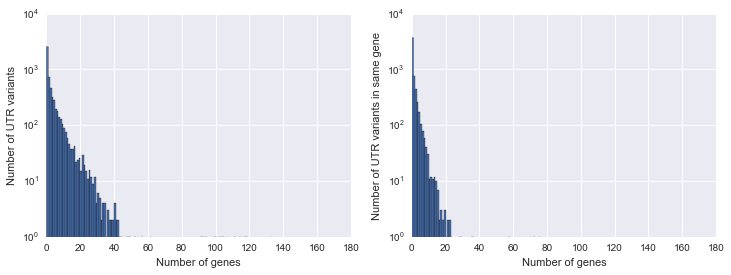

In [41]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.utr.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[0])
ax.set_ylabel('Number of UTR variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.utr_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[1])
ax.set_ylabel('Number of UTR variants in same gene')
ax.set_xlabel('Number of genes');

In [42]:
for c in [x for x in gene_variants.columns if 'dnase' in x]:
    vc = gene_variants[c].value_counts()
    print('{}\t{:.2f}%'.format(c, float(vc[True]) / vc.sum()))

iPS_DF_6.9_roadmap_dnase	0.05%
iPS_DF_19.11_roadmap_dnase	0.05%
H1_roadmap_dnase	0.04%
H9_roadmap_dnase	0.05%
iPSC_ENCSR000EKK_dnase	0.04%
iPSC_ENCSR000EKJ_dnase	0.04%
iPSC_ENCSR000EKI_dnase	0.05%
iPSC_ENCSR000EKH_dnase	0.02%
H7-hESC_ENCSR000EMZ_dnase	0.02%
H1-hESC_ENCSR000EMU_dnase	0.01%
H9_ENCSR000EJP_dnase	0.02%
H7-hESC_ENCSR000EJO_dnase	0.07%
H1-hESC_ENCSR000EJN_dnase	0.06%


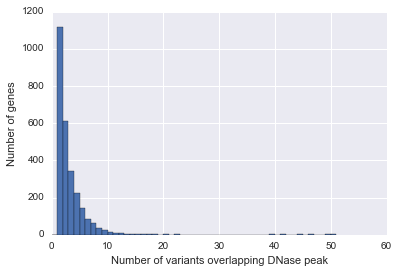

In [43]:
vc = gene_variants.ix[gene_variants['H1-hESC_ENCSR000EMU_dnase'] == True, 'gene_id'].value_counts()
vc.hist(bins=range(0, vc.max() + 1))
plt.ylabel('Number of genes')
plt.xlabel('Number of variants overlapping DNase peak');

In [44]:
gene_variants['significance.level_maurano'].value_counts()

not_imbalanced           27577
imbalanced_(5%_FDR)       5715
imbalanced_(0.1%_FDR)      612
Name: significance.level_maurano, dtype: int64

In [45]:
maurano_res['significance.level_maurano'].value_counts()

not_imbalanced           297687
imbalanced_(5%_FDR)       55141
imbalanced_(0.1%_FDR)      9456
Name: significance.level_maurano, dtype: int64

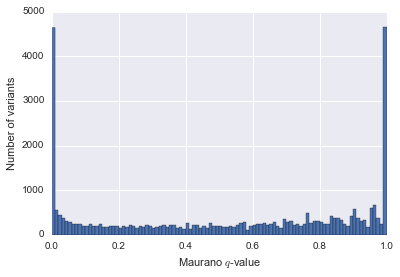

In [46]:
gene_variants['q.value_maurano'].hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $q$-value');

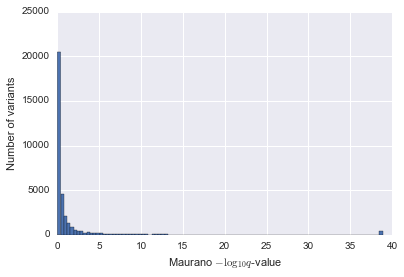

In [47]:
se = gene_variants['q.value_maurano'].dropna()
se += se[se > 0].min()
(-np.log10(se)).hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $-\log_{10}q$-value');

### Single variant genes

I'm going to look at genes for which there is only one significant
variant. In theory, these should often be the causal variants.

In [48]:
se = gene_variants.gene_id.value_counts() == 1
genes = set(se[se].index)
tdf = gene_variants[gene_variants.gene_id.apply(lambda x: x in genes)]

In [49]:
n = tdf.exonic.value_counts()[True]
print('{} of {} genes have an exonic variant.'.format(n, tdf.shape[0]))
n = tdf.utr.value_counts()[True]
print('{} of {} genes have a UTR variant.'.format(n, tdf.shape[0]))
n = tdf['H1-hESC_ENCSR000EMU_dnase'].value_counts()[True]
print('{} of {} genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.'.format(n, tdf.shape[0]))

82 of 721 genes have an exonic variant.
39 of 721 genes have a UTR variant.
44 of 721 genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.


In [50]:
maurano_res['significance.level_maurano'].value_counts() / maurano_res.shape[0]

not_imbalanced           0.821695
imbalanced_(5%_FDR)      0.152204
imbalanced_(0.1%_FDR)    0.026101
Name: significance.level_maurano, dtype: float64

In [51]:
gene_variants['significance.level_maurano'].value_counts() / gene_variants['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.813385
imbalanced_(5%_FDR)      0.168564
imbalanced_(0.1%_FDR)    0.018051
Name: significance.level_maurano, dtype: float64

In [52]:
tdf['significance.level_maurano'].value_counts() / tdf['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.780488
imbalanced_(5%_FDR)      0.207317
imbalanced_(0.1%_FDR)    0.012195
Name: significance.level_maurano, dtype: float64

In [55]:
t = gene_variants.sort_values(by=['gene_id', 'pvalue'])
t = t.drop_duplicates(subset='gene_id')

In [56]:
t['significance.level_maurano'].value_counts() / t['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.740940
imbalanced_(5%_FDR)      0.242953
imbalanced_(0.1%_FDR)    0.016107
Name: significance.level_maurano, dtype: float64

## Fine Mapping

[Wen et al. 2015](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005176) says 50% of cis-eQTLs are concentrated within 20kb of the TSS.

I'll start by removing genes that have significant variants in their exons or
UTRs or are predicted to undergo NMD.

In [57]:
gene_variants_f = gene_variants[(gene_variants.gene_has_nmd_variant == False)]
a = len(set(gene_variants_f.gene_id))
b = len(set(gene_variants.gene_id))
print('{:,} of {:,} genes don\'t have a significant NMD variant.'.format(a, b))

5,749 of 5,760 genes don't have a significant NMD variant.


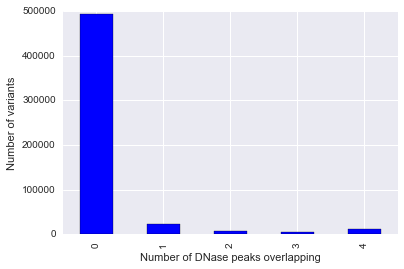

In [58]:
gene_variants_f['roadmap_dnase_num'] = \
    gene_variants_f[[x for x in gene_variants_f.columns 
                    if '_roadmap_dnase' in x]].sum(axis=1)

se = gene_variants_f.roadmap_dnase_num.value_counts()
se = se[range(se.shape[0])]
se.plot(kind='bar')
plt.ylabel('Number of variants')
plt.xlabel('Number of DNase peaks overlapping');

I'm going to keep variants that have some evidence of being functional.

In [59]:
a = len(set(gene_variants.gene_id))
gene_variants_f = gene_variants_f[
    (gene_variants_f.roadmap_dnase_num > 2) | 
    (gene_variants_f['significance.level_maurano'] == 'imbalanced_(5%_FDR)') | 
    (gene_variants_f['significance.level_maurano'] == 'imbalanced_(0.1%_FDR)') | 
    (gene_variants_f.tf_disruption)]
b = len(set(gene_variants_f.gene_id))
print('{:,} of {:,} genes have a putative causal variant.'.format(b, a))

3,745 of 5,760 genes have a putative causal variant.


I'm going to assign variants ranks based on whether

1. Overlaps 2 or more DNase peaks and significant in Maurano **or**
overlaps 2 or more DNase peaks and disrupts a TF
2. Disrupts a TF
3. Significant in Maurano
4. Everything else

I'll sort by this rank and then keep the variant closest to the TSS.

In [60]:
gene_variants_f['variant_rank'] = np.nan
a = gene_variants_f[
    (gene_variants_f.roadmap_dnase_num >= 2) & 
    ((gene_variants_f['significance.level_maurano'] == 'imbalanced_(0.1%_FDR)') |
     (gene_variants_f['significance.level_maurano'] == 'imbalanced_(5%_FDR)'))]
b = gene_variants_f[(gene_variants_f.roadmap_dnase_num >= 2) & 
                   (gene_variants_f.tf_disruption)]
t = pd.concat([a, b]).drop_duplicates()
gene_variants_f.ix[t.index, 'variant_rank'] = 1

gene_variants_f.ix[gene_variants_f.tf_disruption & 
                  gene_variants_f.variant_rank.isnull(), 'variant_rank'] = 2

gene_variants_f.ix[
    ((gene_variants_f['significance.level_maurano'] == 'imbalanced_(0.1%_FDR)') |
     (gene_variants_f['significance.level_maurano'] == 'imbalanced_(5%_FDR)')) &
    gene_variants_f.variant_rank.isnull(), 'variant_rank'] = 3

gene_variants_f.ix[gene_variants_f.variant_rank.isnull(), 'variant_rank'] = 4

In [61]:
gene_variants_f = gene_variants_f.sort_values(by=['variant_rank', 'tss_dist_abs'])
gene_variants_f = gene_variants_f.drop_duplicates(subset='gene_id')

In [62]:
gene_variants_f.tf_disruption.value_counts()

True     2154
False    1591
Name: tf_disruption, dtype: int64

In [63]:
n = gene_variants_f.shape[0] - gene_variants_f['significance.level_maurano'].value_counts().sum()
print('{:,} variants not measured in Maurano'.format(n))

1,748 variants not measured in Maurano


In [64]:
gene_variants_f['significance.level_maurano'].value_counts()

imbalanced_(5%_FDR)      1199
not_imbalanced            697
imbalanced_(0.1%_FDR)     101
Name: significance.level_maurano, dtype: int64

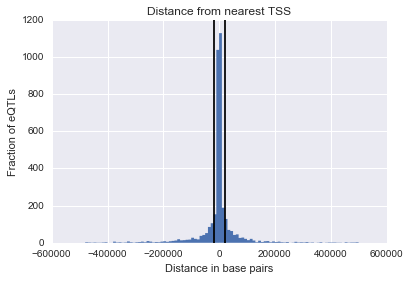

In [65]:
n,b,p = plt.hist(gene_variants_f.tss_dist, 
                 bins=np.arange(-500000, 510000, 10000),
                 histtype='stepfilled',
                 linewidth=0)
ymin, ymax = plt.ylim()
plt.vlines(-20000, ymin, ymax)
plt.vlines(20000, ymin, ymax)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

In [66]:
n = sum(gene_variants_f.tss_dist_abs < 20000)
p = float(n) / gene_variants_f.shape[0]
print('{:,} of {:,} ({:.1f}%) putative causal variants are within 20kb of the nearest TSS.'.format(
        n, gene_variants_f.shape[0], p * 100))

2,505 of 3,745 (66.9%) putative causal variants are within 20kb of the nearest TSS.


In [67]:
s = gene_variants_f[[x for x in gene_variants_f.columns if '_tf_disrupted' in x]].sum()
s = s[s > 0]
s.sort_values(inplace=True, ascending=False)

In [68]:
def calc_bed_enrichment_from_url(url, variants, variants_window):
    """Calculate enrichment for bed file from a URL for variants
    vs. variants_window"""
    from scipy.stats import fisher_exact
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    bt = bt.merge()
    res = variants.intersect(bt, sorted=True, wo=True)
    eqtl_in_peak = len(res)
    eqtl_out_peak = len(variants) - eqtl_in_peak

    res = variants_window.intersect(bt, sorted=True, wo=True)
    not_eqtl_in_peak = 0
    for r in res:
        not_eqtl_in_peak += int(r.fields[-1])
    not_eqtl_in_peak -= eqtl_in_peak
    
    total = 0
    for r in variants_window:
        total += r.length
    not_eqtl_out_peak = total - not_eqtl_in_peak - eqtl_in_peak - eqtl_out_peak
    
    oddsratio, p = fisher_exact([[eqtl_in_peak, eqtl_out_peak],
                                 [not_eqtl_in_peak, not_eqtl_out_peak]])
    return url, oddsratio, p

In [70]:
n = len(set(gene_variants_f.index) & set(lead_variants_single_f.index))
print('{:,} of my putative causal variants are also the most significant variants'.format(n))

388 of my putative causal variants are also the most significant variants


In [71]:
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 'interactions.tsv')
interactions = pd.read_table(fn)

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 
                  'gene_to_containing_interactions.pickle')
gene_to_containing_interactions = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_exon_gene.pickle')
chia_to_exon_gene = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_promoter_gene.pickle')
chia_to_promoter_gene = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_peaks.bed')
chia_peaks = pbt.BedTool(fn)

TODO: Add in RNA pol2 chia pet? Adds some slop to stuff to get more overlaps?

In [72]:
s = '\n'.join(gene_variants_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
gene_variants_f = gene_variants_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                      left_on='location', right_index=True, how='left')

In [73]:
s = '\n'.join(lead_variants_single_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
lead_variants_single_f = lead_variants_single_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                                  left_on='location', right_index=True, how='left')

In [74]:
def get_other_end(peaks):
    if type(peaks) is set:
        other_ends = []
        for p in peaks:
            other_ends += list(interactions.ix[interactions.peak1 == p, 'peak2'])
            other_ends += list(interactions.ix[interactions.peak2 == p, 'peak1'])
        return set(other_ends)
    else:
        return np.nan

In [75]:
gene_variants_f['chia_interaction_peak'] = gene_variants_f.chia_peaks.apply(lambda x: get_other_end(x))
lead_variants_single_f['chia_interaction_peak'] = lead_variants_single_f.chia_peaks.apply(lambda x: get_other_end(x))

In [76]:
def get_promoter_gene(peaks):
    if type(peaks) is set:
        peaks = peaks & set(chia_to_promoter_gene.index)
        genes = []
        for p in peaks:
            genes += list(chia_to_promoter_gene[p])
        out = set(genes)
        if len(out) == 0:
            return np.nan
        else:
            return out
    else:
        return np.nan

In [183]:
sum(gene_variants_f.tss_dist_abs > 10000)

1581

In [184]:
sum(lead_variants_single_f.tss_dist_abs > 10000)

3454

In [77]:
gene_variants_f['chia_interaction_promoter_gene'] = \
    gene_variants_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))
lead_variants_single_f['chia_interaction_promoter_gene'] = \
    lead_variants_single_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))

In [78]:
gene_variants_f['interacts_with_promoter'] = np.nan
t = gene_variants_f[gene_variants_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
gene_variants_f.ix[se.index, 'interacts_with_promoter'] = se

In [79]:
lead_variants_single_f['interacts_with_promoter'] = np.nan
t = lead_variants_single_f[lead_variants_single_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
lead_variants_single_f.ix[se.index, 'interacts_with_promoter'] = se

In [83]:
shared = set(lead_variants_single_f.index) & set(gene_variants_f.index)

In [92]:
a = lead_variants_single_f.interacts_with_promoter.sum()
b = gene_variants_f.interacts_with_promoter.sum()
c = len(set(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].index) 
        & set(gene_variants_f[gene_variants_f.interacts_with_promoter == True].index))
print('{} lead variants and {} putative eQTNs ({} shared) '
      'interact with promoters.'.format(a, b, c))

56 lead variants and 137 putative eQTNs (18 shared) interact with promoters.


In [103]:
lead_interact = lead_variants_single_f.drop(shared).interacts_with_promoter.sum()
lead_no_interact = lead_variants_single_f.drop(shared).shape[0] - lead_interact
put_interact = gene_variants_f.drop(shared).interacts_with_promoter.sum()
put_no_interact = gene_variants_f.drop(shared).shape[0] - put_interact

In [105]:
stats.fisher_exact([[put_interact, put_no_interact], [lead_interact, lead_no_interact]])

(5.2128506875589222, 6.0045495916134227e-22)

In [ ]:
interactions.

In [180]:
interactions.head().T

,0,1,2,3,4
chrom1,chr6,chr10,chr1,chr17,chr11
start1,44139878,28952052,46911238,74362949,1713765
end1,44141467,28954067,46914718,74367319,1716313
chrom2,chr6,chr10,chr1,chr17,chr11
start2,44203219,29421192,46996014,74378730,1845596
end2,44204252,29422575,46997296,74383006,1847309
ID,chr6:44139878-44141467==chr6:44203219-44204252,chr10:28952052-28954067==chr10:29421192-29422575,chr1:46911238-46914718==chr1:46996014-46997296,chr17:74362949-74367319==chr17:74378730-74383006,chr11:1713765-1716313==chr11:1845596-1847309
score,3,3,3,5,16
ctcf_loop,True,False,False,True,True
nep_loop,True,False,False,False,True


In [107]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

In [169]:
def get_hic_interactions(vg):
    chrom,a,gene = vg.split(':')
    start,end = [int(x) for x in a.split('-')]
    r = '{}:{}-{}'.format(chrom, start, end)
    fn = ('/projects/CARDIPS/pipeline/Hi-C/7_indv_HiC/contact_matrices/'
          'merged/normalized/iPSC/iPSC.5Kb.nor.{}.bed.gz'.format(chrom))
    t = tabix.open(fn)
    lines = []
    res = t.querys(r)
    while True:
        try:
            lines.append(res.next())
        except StopIteration:
            break
    # Get promoter regions.
    ps = [cpb.general.parse_region(x) for x in gene_to_promoters[gene]]
    # Get indices of columns for promoter regions.
    cols = []
    for x in ps:
        cols += range(int(x[1]) / 5000, int(x[2]) / 5000 + 1)
    cols = sorted(list(set(cols)))
    vals = []
    # Get values for promoter regions.
    for line in lines:
        vals.append([float(line[x + 3]) for x in cols])
    df = pd.DataFrame(vals)
    df.columns = np.array(cols) * 5000
    df.index = np.arange((start / 5000) * 5000, (start / 5000 + df.shape[0]) * 5000, 5000)
    # Reflect over promoter regions and get interactions on other side.
    cnv_middle = int(start + (end - start) / 2.)
    promoter_middle = int(df.columns[0] + (df.columns[-1] - df.columns[0]) / 2.)
    null_start = int(2 * promoter_middle - cnv_middle - (end - start) / 2.)
    null_end = int(2 * promoter_middle - cnv_middle + (end - start) / 2.)
    if null_start < 0 or null_end < 0:
        return None, None
    else:
        r = '{}:{}-{}'.format(chrom, null_start, null_end)
        lines = []
        res = t.querys(r)
        while True:
            try:
                lines.append(res.next())
            except StopIteration:
                break
        if lines == []:
            return None, None
        else:            
            vals = []
            # Get values for promoter regions.
            for line in lines:
                vals.append([float(line[x + 3]) for x in cols])
            null_df = pd.DataFrame(vals)
            null_df.columns = np.array(cols) * 5000
            null_df.index = np.arange((null_start / 5000) * 5000, (null_start / 5000 + null_df.shape[0]) * 5000, 5000)
            return df, null_df

In [170]:
real = []
null = []
dist = []
for i in gene_variants_f.index:
    df, null_df = get_hic_interactions(i)
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
put_real = pd.Series(real)
put_null = pd.Series(null)

In [176]:
real = []
null = []
dist = []
for i in lead_variants_single_f.index:
    df, null_df = get_hic_interactions(i)
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
lead_real = pd.Series(real)
lead_null = pd.Series(null)

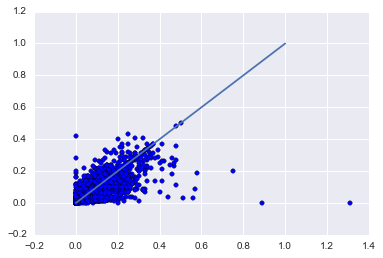

In [175]:
plt.scatter(put_null * 10000, put_real * 10000)
plt.plot([0, 1], [0, 1])

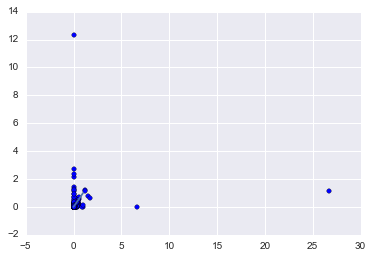

In [177]:
plt.scatter(lead_null * 10000, lead_real * 10000)
plt.plot([0, 1], [0, 1])

In [534]:
sig_variants_f.tf_disruption.value_counts()

True     2388
False    1242
Name: tf_disruption, dtype: int64

In [537]:
sig_variants_f['significance.level_maurano'].value_counts()

imbalanced_(5%_FDR)      1043
not_imbalanced            711
imbalanced_(0.1%_FDR)      98
Name: significance.level_maurano, dtype: int64

In [635]:
se = sig_variants_f[[x for x in sig_variants_f.columns if '_tf_disrupted' in x]].sum()
se.sort_values(inplace=True, ascending=False)

motif_cols = [x for x in sig_variants_f.columns if '_motif_disrupted' in x]
tdf = sig_variants_f[sig_variants_f.tf_disruption]

direction = []
motifs = []
for tf in motif_cols:
    t = tdf[tdf[tf] == True]
    if t.shape[0] > 0:
        motifs.append(tf)
        beta = t.beta
        beta.index = t.variant
        d = motif_d.ix[t.variant, '_'.join(tf.split('_')[0:2])]
        c = pd.crosstab(beta > 0, d > 0)
        a = 0
        if True in c.index and True in c.columns:
            a += c.ix[True, True]
        if False in c.index and False in c.columns:
            a += c.ix[False, False]
        b = 0
        if True in c.index and False in c.columns:
            b += c.ix[True, False]
        if False in c.index and True in c.columns:
            b += c.ix[False, True]
        direction.append([a, b])

In [639]:
df = pd.DataFrame(direction, index=motifs, columns=['repress', 'activate'])
df['tf'] = [x.split('_')[0] for x in df.index]

In [650]:
tf = df.groupby('tf').sum()

In [655]:
tf

,repress,activate
tf,,
AP1,11,13
ATF2,5,8
ATF3,48,56
BACH1,4,3
BCL,2,3
BRCA1,16,6
CEBPB,21,24
CHD2,42,44
CTCF,281,221


TODO: More likely to fall in enhancers?

In [ ]:
# GM12878_CTCF
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872886
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872886&format=file&file='
       'GSM1872886%5FGM12878%5FCTCF%5FPET%5Fclusters%2Etxt%2Egz')

# GM12878_RNAPII
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872887
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872887&format=file&file='
       'GSM1872887%5FGM12878%5FRNAPII%5FPET%5Fclusters%2Etxt%2Egz')
s = cpb.general.read_gzipped_text_url(url)
lines = [x.strip().split('\t') for x in s.split('\n')[:-1]]
gm_rnap = pd.DataFrame(lines, columns=['chr1', 'start1', 'end1',
                                       'chr2', 'start2', 'end2', 'num'])
for c in ['start1', 'start2', 'end1', 'end2', 'num']:
    gm_rnap[c] = gm_rnap[c].astype(int)

# HeLa_CTCF
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872888
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872888&format=file&file='
       'GSM1872888%5FHeLa%5FCTCF%5FPET%5Fclusters%2Etxt%2Egz')

# HeLa_RNAPII
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872889
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872889&format=file&file='
       'GSM1872889%5FHeLa%5FRNAPII%5FPET%5Fclusters%2Etxt%2Egz')
s = cpb.general.read_gzipped_text_url(url)
lines = [x.strip().split('\t') for x in s.split('\n')[:-1]]
hela_rnap = pd.DataFrame(lines, columns=['chr1', 'start1', 'end1',
                                       'chr2', 'start2', 'end2', 'num'])
for c in ['start1', 'start2', 'end1', 'end2', 'num']:
    hela_rnap[c] = hela_rnap[c].astype(int)

In [678]:
hela_rnap.head()

,chr1,start1,end1,chr2,start2,end2,num
0,chr5,172755596,172756703,chr5,172881992,172882886,4
1,chr2,67867350,67867483,chr6,7058521,7058693,2
2,chr16,76131648,76131707,chr3,99478080,99478116,2
3,chr19,50786267,50786519,chr2,161650567,161650666,2
4,chr14,31550371,31550417,chr5,5930449,5930510,3


TODO: I can also compare conservation.